# Trabajo Final - Parte 3: Análisis de Políticas Públicas
## Visualización de Datos - Latinobarómetro 2024

Este notebook contiene el análisis de dos preguntas de investigación relevantes para políticas públicas, explorando relaciones y correlaciones entre variables del Latinobarómetro 2024.


In [35]:
# Instalación de dependencias necesarias
!pip install pandas numpy matplotlib seaborn plotly scipy -q


In [36]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Para mostrar todas las columnas en pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)


## 1. Carga y Preparación de Datos


In [37]:
# Carga de datos principales
df = pd.read_csv('../data/Latinobarometro_2024.csv', sep=';', encoding='utf-8')

# Carga de códigos de países
country_codes = pd.read_csv('../data/country_codes.csv', encoding='utf-8')

# Merge con códigos de países
df = df.merge(country_codes, left_on='IDENPA', right_on='Country Code', how='left')
df['Country Name'] = df['Country Name'].fillna('Unknown')

print(f"Dimensiones del dataset: {df.shape}")
print(f"Países incluidos: {df['Country Name'].nunique()}")
print(f"\nPaíses y número de encuestados:")
print(df['Country Name'].value_counts().sort_index())


Dimensiones del dataset: (19214, 334)
Países incluidos: 17

Países y número de encuestados:
Country Name
Argentina          1210
Bolivia            1200
Brasil             1204
Chile              1200
Colombia           1200
Costa Rica         1000
Ecuador            1200
El Salvador        1000
Guatemala          1000
Honduras           1000
México             1200
Panamá             1000
Paraguay           1200
Perú               1200
Rep. Dominicana    1000
Uruguay            1200
Venezuela          1200
Name: count, dtype: int64


In [38]:
# Preparación de variables principales

# Variables demográficas
df['sexo_label'] = df['SEXO'].map({1: 'Hombre', 2: 'Mujer'})
df['grupo_edad'] = pd.cut(df['EDAD'], bins=[0, 25, 35, 45, 55, 65, 100], 
                          labels=['16-25', '26-35', '36-45', '46-55', '56-65', '66+'])

# Educación
df['anos_estudio'] = df['REEDUC.3'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
df['grupo_educativo'] = pd.cut(df['anos_estudio'], bins=[0, 6, 12, 99], 
                                labels=['Primaria (0-6)', 'Secundaria (7-12)', 'Universidad (13+)'],
                                include_lowest=True)

# Confianza en instituciones (S14M.1 = Gobierno, S14M.2 = Partidos políticos, etc.)
df['confianza_gobierno'] = df['S14M.1'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
df['confianza_partidos'] = df['S14M.2'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
df['confianza_congreso'] = df['S14M.3'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
df['confianza_poder_judicial'] = df['S14M.4'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
df['confianza_policia'] = df['S14M.5'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)

# Satisfacción con la democracia (S16)
df['satisfaccion_democracia'] = df['S16'].replace([-1, -2, -3, -4, -5, 96, 97, 98, 99], np.nan)

# Interés en política (S17)
df['interes_politica'] = df['S17'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)

# Participación política (S17.A, S17.B, S17.C)
df['participacion_debate'] = df['S17.A'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
df['participacion_manifestacion'] = df['S17.B'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
df['participacion_organizacion'] = df['S17.C'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)

# Acceso a internet (S7: 1=Sí, 2=No)
df['acceso_internet'] = df['S7'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
df['tiene_internet'] = df['acceso_internet'].map({1: 'Sí', 2: 'No'})

# Confianza en medios (P23STM.1 = TV, P23STM.2 = Redes sociales, P23STM.3 = Otro)
df['confianza_tv'] = df['P23STM.1'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
df['confianza_redes'] = df['P23STM.2'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
df['confianza_otro_medio'] = df['P23STM.3'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)

# Uso de redes sociales (P28ST)
df['uso_redes'] = df['P28ST'].replace([-1, -2, -3, -5, 96, 97, 98, 99], np.nan)
# Mapear valores según codebook (asumiendo: 1=Diario, 2=Semanal, 3=Nunca)
df['uso_redes_label'] = df['uso_redes'].map({1: 'Diario', 2: 'Semanal', 3: 'Nunca'})

# Filtrar datos de Uruguay para análisis focalizado
uruguay_code = 858
df_uy = df[df['IDENPA'] == uruguay_code].copy()

print("Variables preparadas exitosamente")
print(f"\nRegistros válidos por variable (Total):")
print(f"  - Años de estudio: {df['anos_estudio'].notna().sum()}")
print(f"  - Confianza en gobierno: {df['confianza_gobierno'].notna().sum()}")
print(f"  - Satisfacción democracia: {df['satisfaccion_democracia'].notna().sum()}")
print(f"  - Interés en política: {df['interes_politica'].notna().sum()}")
print(f"  - Acceso internet: {df['acceso_internet'].notna().sum()}")
print(f"  - Confianza redes: {df['confianza_redes'].notna().sum()}")
print(f"  - Uso redes: {df['uso_redes'].notna().sum()}")

print(f"\n\nRegistros válidos por variable (Uruguay):")
print(f"  - Total registros Uruguay: {len(df_uy)}")
print(f"  - Años de estudio: {df_uy['anos_estudio'].notna().sum()}")
print(f"  - Confianza en gobierno: {df_uy['confianza_gobierno'].notna().sum()}")
print(f"  - Satisfacción democracia: {df_uy['satisfaccion_democracia'].notna().sum()}")
print(f"  - Interés en política: {df_uy['interes_politica'].notna().sum()}")
print(f"  - Acceso internet: {df_uy['acceso_internet'].notna().sum()}")
print(f"  - Confianza redes: {df_uy['confianza_redes'].notna().sum()}")
print(f"  - Uso redes: {df_uy['uso_redes'].notna().sum()}")


Variables preparadas exitosamente

Registros válidos por variable (Total):
  - Años de estudio: 9633
  - Confianza en gobierno: 19214
  - Satisfacción democracia: 19200
  - Interés en política: 18893
  - Acceso internet: 17389
  - Confianza redes: 16589
  - Uso redes: 18730


Registros válidos por variable (Uruguay):
  - Total registros Uruguay: 1200
  - Años de estudio: 494
  - Confianza en gobierno: 1200
  - Satisfacción democracia: 1199
  - Interés en política: 1200
  - Acceso internet: 1130
  - Confianza redes: 1032
  - Uso redes: 1149


## 2. Preguntas de Investigación para Políticas Públicas

### 2.1. Pregunta 1: Educación y Confianza Institucional en Uruguay

**Pregunta de investigación:**
¿Cómo se relaciona el nivel educativo con la confianza en instituciones gubernamentales, la satisfacción con la democracia y el interés político en Uruguay, y cómo se compara esta relación con el contexto regional?

**Justificación de la elección:**
Esta pregunta es relevante para políticas públicas en Uruguay porque:

1. **Evidencia empírica previa**: Los datos del Latinobarómetro muestran que Uruguay tiene características democráticas particulares (alta satisfacción democrática relativa). Entender si la educación juega un papel diferente aquí es crucial.

2. **Políticas educativas específicas**: Uruguay ha implementado políticas educativas innovadoras (Plan Ceibal, reformas educativas). Es importante evaluar si estas políticas han impactado la participación política y la confianza institucional.

3. **Desigualdad política**: Si existe una brecha educativa en términos de participación y confianza, esto puede indicar la necesidad de políticas inclusivas específicas para Uruguay.

4. **Comparación regional**: Al comparar con otros países latinoamericanos, podemos identificar si Uruguay tiene patrones únicos que requieren políticas diferenciadas.

5. **Relevancia para fortalecimiento democrático**: La confianza en instituciones es fundamental para la estabilidad democrática. Si la educación está correlacionada con mayor confianza en Uruguay, esto justifica inversiones continuas en educación cívica.

**Variables del Latinobarómetro a analizar:**
- **Variable independiente principal**: Nivel educativo (REEDUC.3 - años de estudio, grupos educativos)
- **Variables dependientes**: 
  - Confianza en gobierno (S14M.1)
  - Satisfacción con la democracia (S16)
  - Interés en política (S17)
  - Confianza en otras instituciones (S14M.2-S14M.11: partidos políticos, congreso, poder judicial, etc.)
- **Variables de control**: Edad (EDAD), sexo (SEXO), acceso a internet (S7)
- **Comparación**: Análisis por país para comparar Uruguay con otros países latinoamericanos

### 2.2. Pregunta 2: Brecha Digital, Redes Sociales y Participación Política en Uruguay

**Pregunta de investigación:**
¿Existe una relación entre el acceso a internet, el uso de redes sociales, la confianza en redes sociales y la participación política (interés en política, confianza en gobierno) en Uruguay, y cómo esta relación difiere según el nivel educativo y la edad?

**Justificación de la elección:**
Esta pregunta es relevante para políticas públicas en Uruguay porque:

1. **Plan Ceibal y políticas digitales**: Uruguay fue pionero en políticas de inclusión digital (Plan Ceibal desde 2007). Es crucial evaluar si estas políticas han impactado la participación política y si persisten brechas.

2. **Democracia digital emergente**: Los gobiernos uruguayos están migrando servicios y comunicación a plataformas digitales. Entender quién queda excluido es crucial para políticas de gobierno digital.

3. **Desinformación y confianza**: Las redes sociales pueden influir en la confianza en instituciones. Comprender esta relación ayuda a diseñar políticas de alfabetización mediática y combate a la desinformación.

4. **Brecha generacional y educativa**: La brecha digital puede estar creando nuevas formas de exclusión política que se intersectan con edad y educación. Esto requiere políticas específicas.

5. **Participación ciudadana digital**: Si las redes sociales facilitan la participación política, esto tiene implicaciones para políticas de gobierno abierto, transparencia y participación ciudadana digital.

**Variables del Latinobarómetro a analizar:**
- **Variables independientes**: 
  - Acceso a internet (S7)
  - Uso de redes sociales (P28ST, P28ST.A-P28ST.D)
  - Confianza en redes sociales (P23STM.2)
  - Confianza en TV (P23STM.1) para comparación
- **Variables dependientes**: 
  - Interés en política (S17)
  - Confianza en gobierno (S14M.1)
  - Satisfacción con la democracia (S16)
  - Participación política (S17.A, S17.B, S17.C)
- **Variables de control**: Nivel educativo (REEDUC.3), edad (EDAD), sexo (SEXO)
- **Análisis de interacción**: Educación × Acceso a Internet, Edad × Uso de Redes


## 3. Análisis de la Pregunta 1: Educación y Confianza Institucional

### 3.1. Análisis Descriptivo: Uruguay vs. Comparación Regional


### 3.2. Comparación Regional: Posición de Uruguay


In [39]:
# Comparación: Correlación educación-confianza gobierno por país (para contextualizar Uruguay)
correlaciones_pais = []
for pais in df['Country Name'].unique():
    df_pais = df[df['Country Name'] == pais]
    corr = df_pais[['anos_estudio', 'confianza_gobierno']].corr().iloc[0, 1]
    if not np.isnan(corr):
        correlaciones_pais.append({'País': pais, 'Correlación': corr})

corr_df = pd.DataFrame(correlaciones_pais).sort_values('Correlación', ascending=False)
corr_uruguay = corr_df[corr_df['País'] == 'Uruguay']['Correlación'].values[0] if len(corr_df[corr_df['País'] == 'Uruguay']) > 0 else None

print("="*70)
print("COMPARACIÓN REGIONAL: Correlación Educación-Confianza Gobierno")
print("="*70)
print("\nCorrelación entre años de estudio y confianza en gobierno por país:")
print(corr_df.to_string(index=False))

if corr_uruguay is not None:
    posicion_uruguay = (corr_df['Correlación'] > corr_uruguay).sum() + 1
    print(f"\n\nPosición de Uruguay: {posicion_uruguay} de {len(corr_df)} países")
    print(f"Correlación Uruguay: {corr_uruguay:.4f}")
    print(f"Promedio regional: {corr_df['Correlación'].mean():.4f}")
    print(f"Diferencia: {corr_uruguay - corr_df['Correlación'].mean():.4f}")


COMPARACIÓN REGIONAL: Correlación Educación-Confianza Gobierno

Correlación entre años de estudio y confianza en gobierno por país:
           País  Correlación
        Bolivia     0.213210
      Guatemala     0.205684
      Venezuela     0.191750
           Perú     0.155298
        Ecuador     0.089402
         México     0.088286
         Panamá     0.071598
Rep. Dominicana     0.069844
       Colombia     0.065619
          Chile     0.050226
     Costa Rica     0.049302
    El Salvador     0.033850
       Honduras     0.019981
         Brasil     0.013118
      Argentina    -0.012153
       Paraguay    -0.019048
        Uruguay    -0.098059


Posición de Uruguay: 17 de 17 países
Correlación Uruguay: -0.0981
Promedio regional: 0.0699
Diferencia: -0.1679


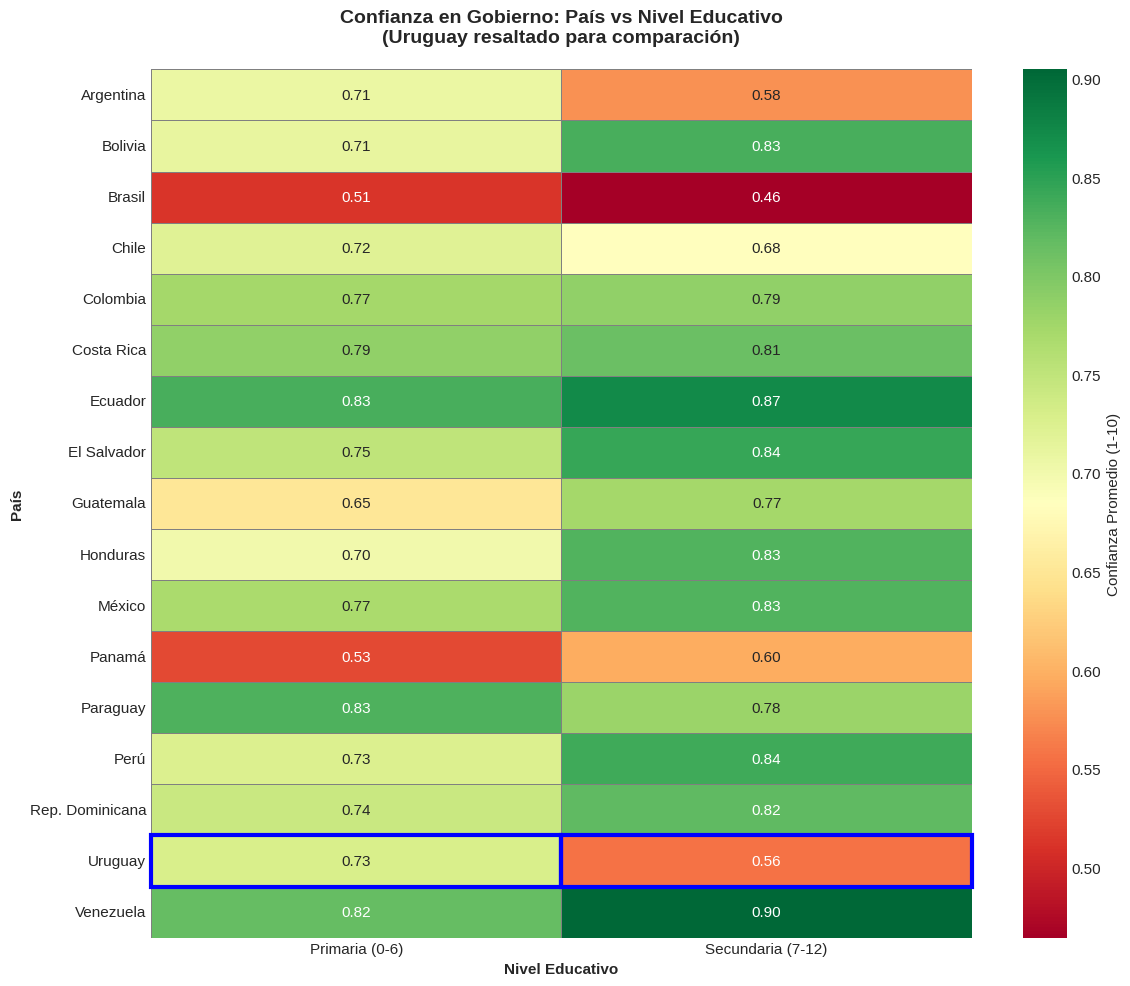

In [40]:
# Visualización: Heatmap de confianza por país y nivel educativo (para contextualizar Uruguay)
pivot_confianza = df.pivot_table(
    values='confianza_gobierno', 
    index='Country Name', 
    columns='grupo_educativo', 
    aggfunc='mean'
)

# Resaltar Uruguay en el heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pivot_confianza, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Confianza Promedio (1-10)'}, 
            linewidths=0.5, linecolor='gray')
plt.title('Confianza en Gobierno: País vs Nivel Educativo\n(Uruguay resaltado para comparación)', 
          fontweight='bold', fontsize=14, pad=20)
plt.xlabel('Nivel Educativo', fontweight='bold')
plt.ylabel('País', fontweight='bold')

# Resaltar la fila de Uruguay
if 'Uruguay' in pivot_confianza.index:
    uruguay_idx = list(pivot_confianza.index).index('Uruguay')
    for i in range(len(pivot_confianza.columns)):
        ax.add_patch(plt.Rectangle((i, uruguay_idx), 1, 1, fill=False, 
                                   edgecolor='blue', lw=3, clip_on=False))

plt.tight_layout()
plt.show()


### 3.3. Análisis de Correlación y Regresión


In [41]:
# Análisis de correlación - Uruguay (con más variables)
variables_educ_uy = ['anos_estudio', 'confianza_gobierno', 'confianza_partidos', 
                     'confianza_congreso', 'confianza_poder_judicial', 'confianza_policia',
                     'satisfaccion_democracia', 'interes_politica', 
                     'participacion_debate', 'participacion_manifestacion']
corr_matrix_uy = df_uy[variables_educ_uy].corr()

print("="*70)
print("MATRIZ DE CORRELACIÓN - URUGUAY")
print("="*70)
print("Variables: Educación vs Confianza Institucional y Participación")
print(corr_matrix_uy.round(3))

# Test de significancia estadística - Uruguay
print("\n\n" + "="*70)
print("CORRELACIONES SIGNIFICATIVAS - URUGUAY")
print("="*70)
df_clean_uy = df_uy[variables_educ_uy].dropna()
if len(df_clean_uy) > 0:
    print(f"\nNúmero de observaciones: {len(df_clean_uy)}")
    print("\nCorrelaciones entre años de estudio y otras variables:")
    for var in ['confianza_gobierno', 'confianza_partidos', 'confianza_congreso', 
                'confianza_poder_judicial', 'satisfaccion_democracia', 'interes_politica']:
        if var in df_clean_uy.columns:
            corr_coef, p_value = stats.pearsonr(df_clean_uy['anos_estudio'], df_clean_uy[var])
            significativo = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
            print(f"  {var}: r={corr_coef:.4f}, p={p_value:.4f} {significativo}")

# Comparación con correlación regional
print("\n\n" + "="*70)
print("COMPARACIÓN: CORRELACIÓN REGIONAL")
print("="*70)
variables_educ_regional = ['anos_estudio', 'confianza_gobierno', 'satisfaccion_democracia', 'interes_politica']
corr_matrix_regional = df[variables_educ_regional].corr()
df_clean_regional = df[variables_educ_regional].dropna()
if len(df_clean_regional) > 0:
    corr_regional, p_regional = stats.pearsonr(df_clean_regional['anos_estudio'], 
                                                df_clean_regional['confianza_gobierno'])
    corr_uy, p_uy = stats.pearsonr(df_clean_uy['anos_estudio'], df_clean_uy['confianza_gobierno'])
    print(f"Correlación educación-confianza gobierno:")
    print(f"  Regional: r={corr_regional:.4f}, p={p_regional:.4f}")
    print(f"  Uruguay:  r={corr_uy:.4f}, p={p_uy:.4f}")
    print(f"  Diferencia: {corr_uy - corr_regional:.4f}")


MATRIZ DE CORRELACIÓN - URUGUAY
Variables: Educación vs Confianza Institucional y Participación
                             anos_estudio  confianza_gobierno  \
anos_estudio                        1.000              -0.098   
confianza_gobierno                 -0.098               1.000   
confianza_partidos                 -0.042               0.084   
confianza_congreso                  0.089               0.257   
confianza_poder_judicial            0.106               0.045   
confianza_policia                   0.004               0.260   
satisfaccion_democracia             0.101              -0.019   
interes_politica                   -0.096               0.206   
participacion_debate               -0.119               0.007   
participacion_manifestacion         0.026               0.036   

                             confianza_partidos  confianza_congreso  \
anos_estudio                             -0.042               0.089   
confianza_gobierno                        0.08

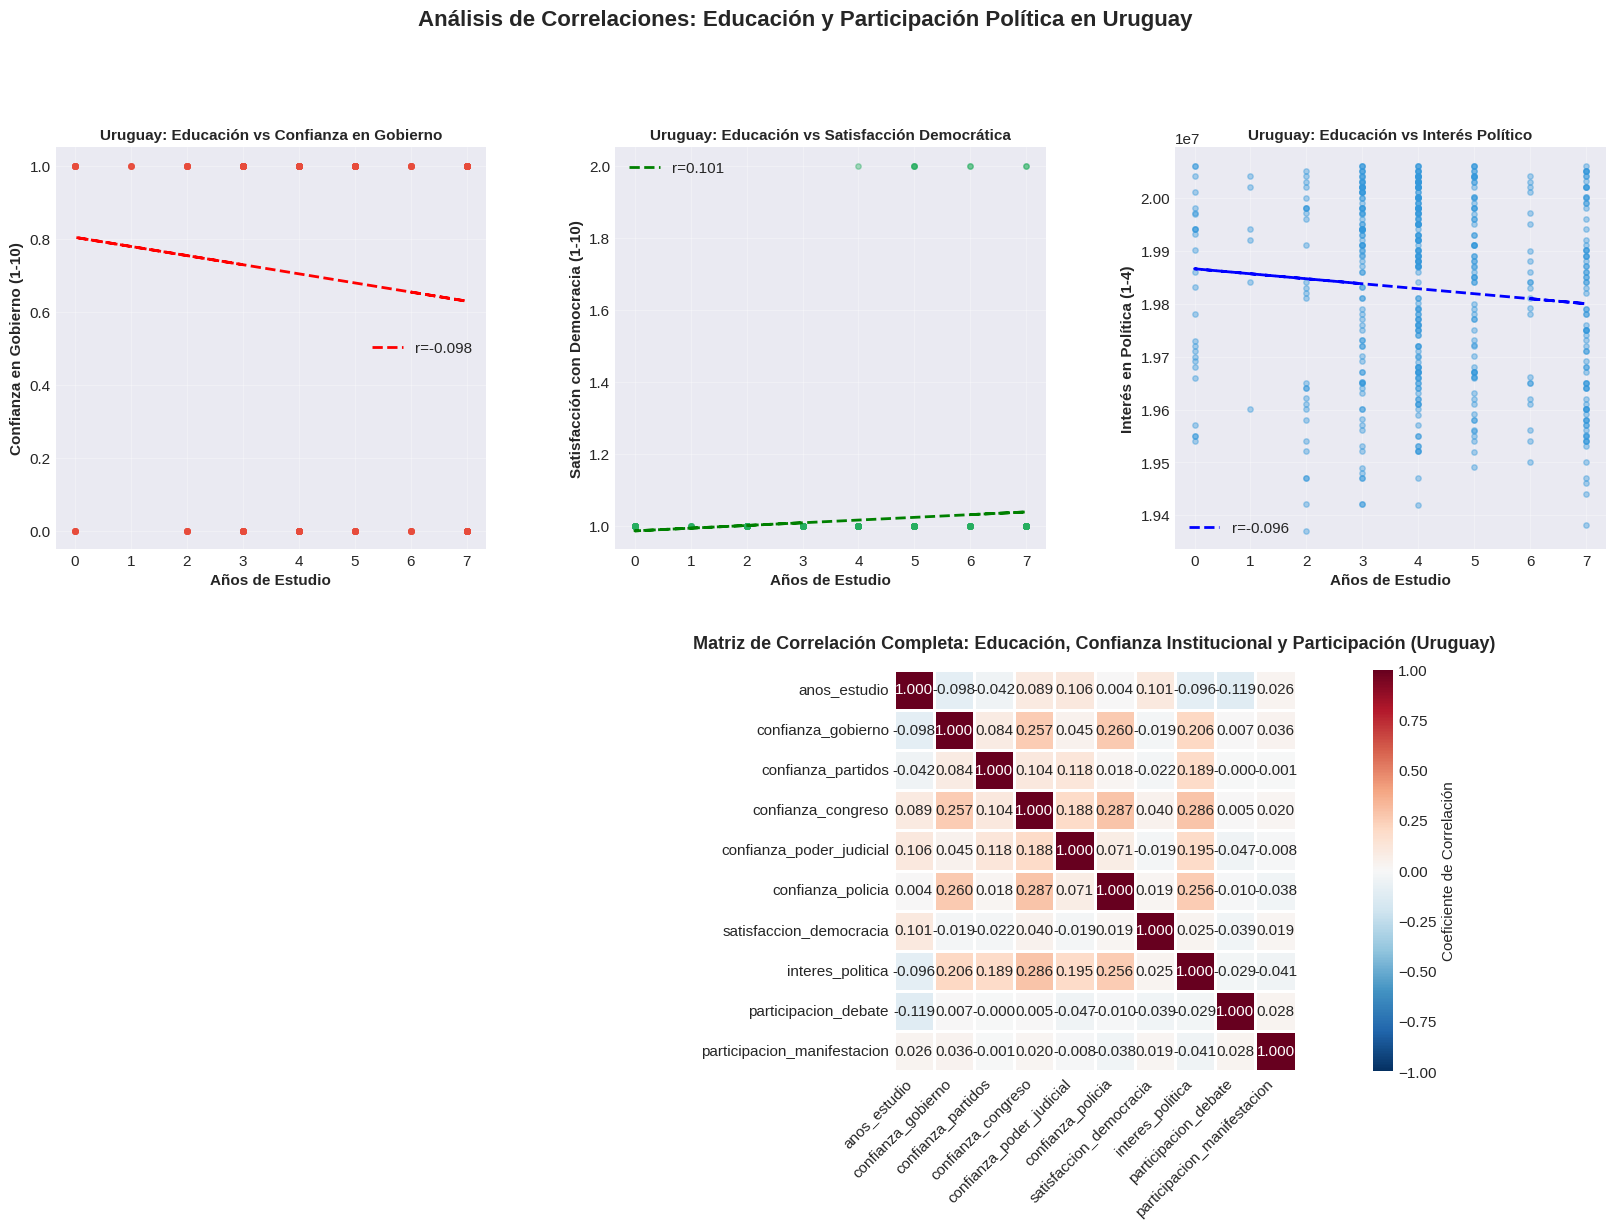

In [42]:
# Visualización: Scatter plots y heatmap de correlaciones - Uruguay
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Educación vs Confianza en gobierno - Uruguay
ax1 = fig.add_subplot(gs[0, 0])
df_clean1_uy = df_uy[['anos_estudio', 'confianza_gobierno']].dropna()
ax1.scatter(df_clean1_uy['anos_estudio'], df_clean1_uy['confianza_gobierno'], 
            alpha=0.4, s=15, color='#e74c3c')
if len(df_clean1_uy) > 1:
    z = np.polyfit(df_clean1_uy['anos_estudio'], df_clean1_uy['confianza_gobierno'], 1)
    p = np.poly1d(z)
    corr_val = stats.pearsonr(df_clean1_uy['anos_estudio'], df_clean1_uy['confianza_gobierno'])[0]
    ax1.plot(df_clean1_uy['anos_estudio'], p(df_clean1_uy['anos_estudio']), 
             "r--", linewidth=2, label=f'r={corr_val:.3f}')
ax1.set_xlabel('Años de Estudio', fontweight='bold')
ax1.set_ylabel('Confianza en Gobierno (1-10)', fontweight='bold')
ax1.set_title('Uruguay: Educación vs Confianza en Gobierno', fontweight='bold', fontsize=11)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Educación vs Satisfacción con democracia - Uruguay
ax2 = fig.add_subplot(gs[0, 1])
df_clean2_uy = df_uy[['anos_estudio', 'satisfaccion_democracia']].dropna()
ax2.scatter(df_clean2_uy['anos_estudio'], df_clean2_uy['satisfaccion_democracia'], 
            alpha=0.4, s=15, color='#27ae60')
if len(df_clean2_uy) > 1:
    z2 = np.polyfit(df_clean2_uy['anos_estudio'], df_clean2_uy['satisfaccion_democracia'], 1)
    p2 = np.poly1d(z2)
    corr_val2 = stats.pearsonr(df_clean2_uy['anos_estudio'], df_clean2_uy['satisfaccion_democracia'])[0]
    ax2.plot(df_clean2_uy['anos_estudio'], p2(df_clean2_uy['anos_estudio']), 
             "g--", linewidth=2, label=f'r={corr_val2:.3f}')
ax2.set_xlabel('Años de Estudio', fontweight='bold')
ax2.set_ylabel('Satisfacción con Democracia (1-10)', fontweight='bold')
ax2.set_title('Uruguay: Educación vs Satisfacción Democrática', fontweight='bold', fontsize=11)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Educación vs Interés en política - Uruguay
ax3 = fig.add_subplot(gs[0, 2])
df_clean3_uy = df_uy[['anos_estudio', 'interes_politica']].dropna()
ax3.scatter(df_clean3_uy['anos_estudio'], df_clean3_uy['interes_politica'], 
            alpha=0.4, s=15, color='#3498db')
if len(df_clean3_uy) > 1:
    z3 = np.polyfit(df_clean3_uy['anos_estudio'], df_clean3_uy['interes_politica'], 1)
    p3 = np.poly1d(z3)
    corr_val3 = stats.pearsonr(df_clean3_uy['anos_estudio'], df_clean3_uy['interes_politica'])[0]
    ax3.plot(df_clean3_uy['anos_estudio'], p3(df_clean3_uy['anos_estudio']), 
             "b--", linewidth=2, label=f'r={corr_val3:.3f}')
ax3.set_xlabel('Años de Estudio', fontweight='bold')
ax3.set_ylabel('Interés en Política (1-4)', fontweight='bold')
ax3.set_title('Uruguay: Educación vs Interés Político', fontweight='bold', fontsize=11)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Heatmap de correlaciones - Uruguay (grande)
ax4 = fig.add_subplot(gs[1, :])
sns.heatmap(corr_matrix_uy, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Coeficiente de Correlación'},
            ax=ax4, vmin=-1, vmax=1, xticklabels=True, yticklabels=True)
ax4.set_title('Matriz de Correlación Completa: Educación, Confianza Institucional y Participación (Uruguay)', 
              fontweight='bold', fontsize=13, pad=15)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0)

plt.suptitle('Análisis de Correlaciones: Educación y Participación Política en Uruguay', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## 4. Análisis de la Pregunta 2: Brecha Digital y Participación Política

### 4.1. Análisis Descriptivo: Acceso a Internet y Uso de Redes


In [43]:
# Estadísticas por acceso a internet - Uruguay
internet_stats_uy = df_uy.groupby('tiene_internet').agg({
    'interes_politica': ['mean', 'std', 'count'],
    'confianza_gobierno': ['mean', 'std'],
    'satisfaccion_democracia': ['mean', 'std']
}).round(2)

print("="*70)
print("ESTADÍSTICAS POR ACCESO A INTERNET - URUGUAY")
print("="*70)
print(internet_stats_uy)

# Comparación con promedio regional
internet_stats_regional = df.groupby('tiene_internet').agg({
    'interes_politica': 'mean',
    'confianza_gobierno': 'mean',
    'satisfaccion_democracia': 'mean'
}).round(2)

print("\n\n" + "="*70)
print("COMPARACIÓN: URUGUAY vs PROMEDIO REGIONAL")
print("="*70)
print("Interés en política:")
print(f"  Uruguay - Con Internet: {internet_stats_uy.loc['Sí', ('interes_politica', 'mean')]:.2f}")
print(f"  Regional - Con Internet: {internet_stats_regional.loc['Sí', 'interes_politica']:.2f}")
print(f"  Diferencia: {internet_stats_uy.loc['Sí', ('interes_politica', 'mean')] - internet_stats_regional.loc['Sí', 'interes_politica']:.2f}")

print("\n\nEstadísticas por uso de redes sociales - Uruguay:")
redes_stats_uy = df_uy.groupby('uso_redes_label').agg({
    'interes_politica': ['mean', 'std', 'count'],
    'confianza_gobierno': ['mean', 'std'],
    'confianza_redes': ['mean', 'std']
}).round(2)
print(redes_stats_uy)


ESTADÍSTICAS POR ACCESO A INTERNET - URUGUAY
               interes_politica                  confianza_gobierno        \
                           mean        std count               mean   std   
tiene_internet                                                              
No                  19837652.81  156863.74    62               0.79  0.41   
Sí                  19923086.25  116825.98     4               1.00  0.00   

               satisfaccion_democracia        
                                  mean   std  
tiene_internet                                
No                                1.03  0.18  
Sí                                1.00  0.00  


COMPARACIÓN: URUGUAY vs PROMEDIO REGIONAL
Interés en política:
  Uruguay - Con Internet: 19923086.25
  Regional - Con Internet: 19853460.34
  Diferencia: 69625.91


Estadísticas por uso de redes sociales - Uruguay:
                interes_politica                  confianza_gobierno        \
                            mean       

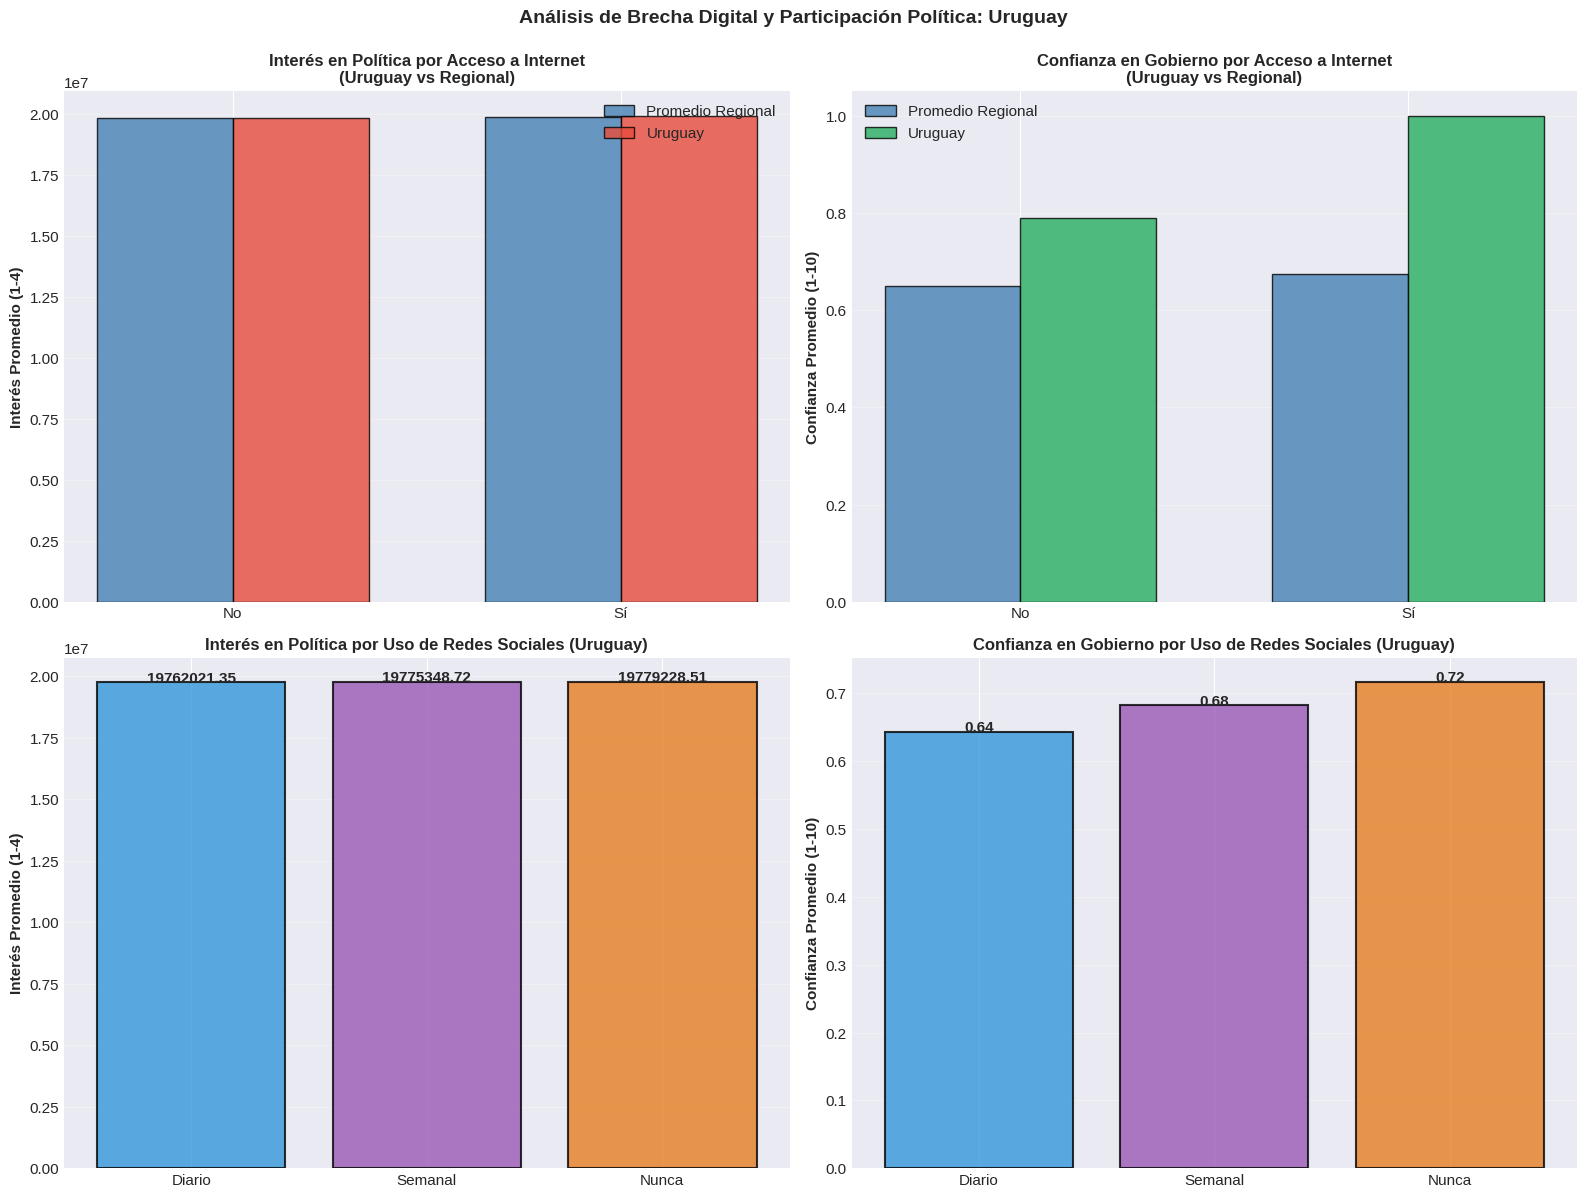

In [44]:
# Visualización: Comparación entre quienes tienen y no tienen internet - Uruguay
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Interés en política por acceso a internet - Uruguay vs Regional
internet_interes_uy = df_uy.groupby('tiene_internet')['interes_politica'].mean()
internet_interes_regional = df.groupby('tiene_internet')['interes_politica'].mean()

x = np.arange(len(internet_interes_uy.index))
width = 0.35
axes[0, 0].bar(x - width/2, internet_interes_regional.values, width, 
               label='Promedio Regional', color='steelblue', alpha=0.8, edgecolor='black')
axes[0, 0].bar(x + width/2, internet_interes_uy.values, width, 
               label='Uruguay', color='#e74c3c', alpha=0.8, edgecolor='black')
axes[0, 0].set_ylabel('Interés Promedio (1-4)', fontweight='bold')
axes[0, 0].set_title('Interés en Política por Acceso a Internet\n(Uruguay vs Regional)', fontweight='bold', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(internet_interes_uy.index)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Confianza en gobierno por acceso a internet - Uruguay vs Regional
internet_confianza_uy = df_uy.groupby('tiene_internet')['confianza_gobierno'].mean()
internet_confianza_regional = df.groupby('tiene_internet')['confianza_gobierno'].mean()

axes[0, 1].bar(x - width/2, internet_confianza_regional.values, width, 
               label='Promedio Regional', color='steelblue', alpha=0.8, edgecolor='black')
axes[0, 1].bar(x + width/2, internet_confianza_uy.values, width, 
               label='Uruguay', color='#27ae60', alpha=0.8, edgecolor='black')
axes[0, 1].set_ylabel('Confianza Promedio (1-10)', fontweight='bold')
axes[0, 1].set_title('Confianza en Gobierno por Acceso a Internet\n(Uruguay vs Regional)', fontweight='bold', fontsize=12)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(internet_confianza_uy.index)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Interés en política por uso de redes sociales - Uruguay
redes_interes_uy = df_uy.groupby('uso_redes_label')['interes_politica'].mean()
orden_redes = ['Diario', 'Semanal', 'Nunca']
redes_interes_ordenado = redes_interes_uy.reindex([x for x in orden_redes if x in redes_interes_uy.index])
axes[1, 0].bar(redes_interes_ordenado.index, redes_interes_ordenado.values, 
               color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Interés Promedio (1-4)', fontweight='bold')
axes[1, 0].set_title('Interés en Política por Uso de Redes Sociales (Uruguay)', fontweight='bold', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(redes_interes_ordenado.values):
    axes[1, 0].text(i, v, f'\n{v:.2f}', ha='center', fontweight='bold', fontsize=11)

# 4. Confianza en gobierno por uso de redes sociales - Uruguay
redes_confianza_uy = df_uy.groupby('uso_redes_label')['confianza_gobierno'].mean()
redes_confianza_ordenado = redes_confianza_uy.reindex([x for x in orden_redes if x in redes_confianza_uy.index])
axes[1, 1].bar(redes_confianza_ordenado.index, redes_confianza_ordenado.values, 
               color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Confianza Promedio (1-10)', fontweight='bold')
axes[1, 1].set_title('Confianza en Gobierno por Uso de Redes Sociales (Uruguay)', fontweight='bold', fontsize=12)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(redes_confianza_ordenado.values):
    axes[1, 1].text(i, v, f'\n{v:.2f}', ha='center', fontweight='bold', fontsize=11)

plt.suptitle('Análisis de Brecha Digital y Participación Política: Uruguay', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


### 4.2. Comparación Regional: Posición de Uruguay en Brecha Digital


In [45]:
# Comparación regional: Acceso a internet y brecha digital (para contextualizar Uruguay)
acceso_por_pais = df.groupby('Country Name')['tiene_internet'].value_counts(normalize=True).unstack() * 100
acceso_por_pais = acceso_por_pais.sort_values('Sí', ascending=False)

print("="*70)
print("COMPARACIÓN REGIONAL: Acceso a Internet")
print("="*70)
print("\nPorcentaje de acceso a internet por país:")
print(acceso_por_pais.round(1))

if 'Uruguay' in acceso_por_pais.index:
    acceso_uy = acceso_por_pais.loc['Uruguay', 'Sí']
    posicion_uy = (acceso_por_pais['Sí'] > acceso_uy).sum() + 1
    print(f"\n\nPosición de Uruguay: {posicion_uy} de {len(acceso_por_pais)} países")
    print(f"Acceso Uruguay: {acceso_uy:.1f}%")
    print(f"Promedio regional: {acceso_por_pais['Sí'].mean():.1f}%")
    print(f"Diferencia: {acceso_uy - acceso_por_pais['Sí'].mean():.1f} puntos porcentuales")

# Diferencia en interés político entre quienes tienen y no tienen internet por país
diferencias = []
for pais in df['Country Name'].unique():
    df_pais = df[df['Country Name'] == pais]
    con_internet = df_pais[df_pais['tiene_internet'] == 'Sí']['interes_politica'].mean()
    sin_internet = df_pais[df_pais['tiene_internet'] == 'No']['interes_politica'].mean()
    if not (np.isnan(con_internet) or np.isnan(sin_internet)):
        diferencias.append({
            'País': pais,
            'Con Internet': con_internet,
            'Sin Internet': sin_internet,
            'Diferencia': con_internet - sin_internet
        })

diferencias_df = pd.DataFrame(diferencias).sort_values('Diferencia', ascending=False)

print("\n\n" + "="*70)
print("COMPARACIÓN REGIONAL: Brecha Digital en Interés Político")
print("="*70)
print("\nDiferencia en interés político (Con Internet - Sin Internet) por país:")
print(diferencias_df.to_string(index=False))

if 'Uruguay' in diferencias_df['País'].values:
    diff_uy = diferencias_df[diferencias_df['País'] == 'Uruguay']['Diferencia'].values[0]
    posicion_diff = (diferencias_df['Diferencia'] > diff_uy).sum() + 1
    print(f"\n\nPosición de Uruguay: {posicion_diff} de {len(diferencias_df)} países")
    print(f"Brecha Uruguay: {diff_uy:.3f}")
    print(f"Promedio regional: {diferencias_df['Diferencia'].mean():.3f}")


COMPARACIÓN REGIONAL: Acceso a Internet

Porcentaje de acceso a internet por país:
tiene_internet      No    Sí
Country Name                
Guatemala         66.7  33.3
Bolivia           73.9  26.1
Perú              78.0  22.0
El Salvador       82.0  18.0
México            83.3  16.7
Honduras          85.2  14.8
Chile             85.7  14.3
Paraguay          87.3  12.7
Rep. Dominicana   91.7   8.3
Argentina         92.9   7.1
Uruguay           93.9   6.1
Costa Rica        94.9   5.1
Panamá            96.9   3.1
Colombia          98.3   1.7
Brasil            99.0   1.0
Ecuador          100.0   NaN
Venezuela        100.0   NaN


Posición de Uruguay: 11 de 17 países
Acceso Uruguay: 6.1%
Promedio regional: 12.7%
Diferencia: -6.6 puntos porcentuales


COMPARACIÓN REGIONAL: Brecha Digital en Interés Político

Diferencia en interés político (Con Internet - Sin Internet) por país:
           País  Con Internet  Sin Internet     Diferencia
     Costa Rica  1.997026e+07  1.977664e+07  193624.29

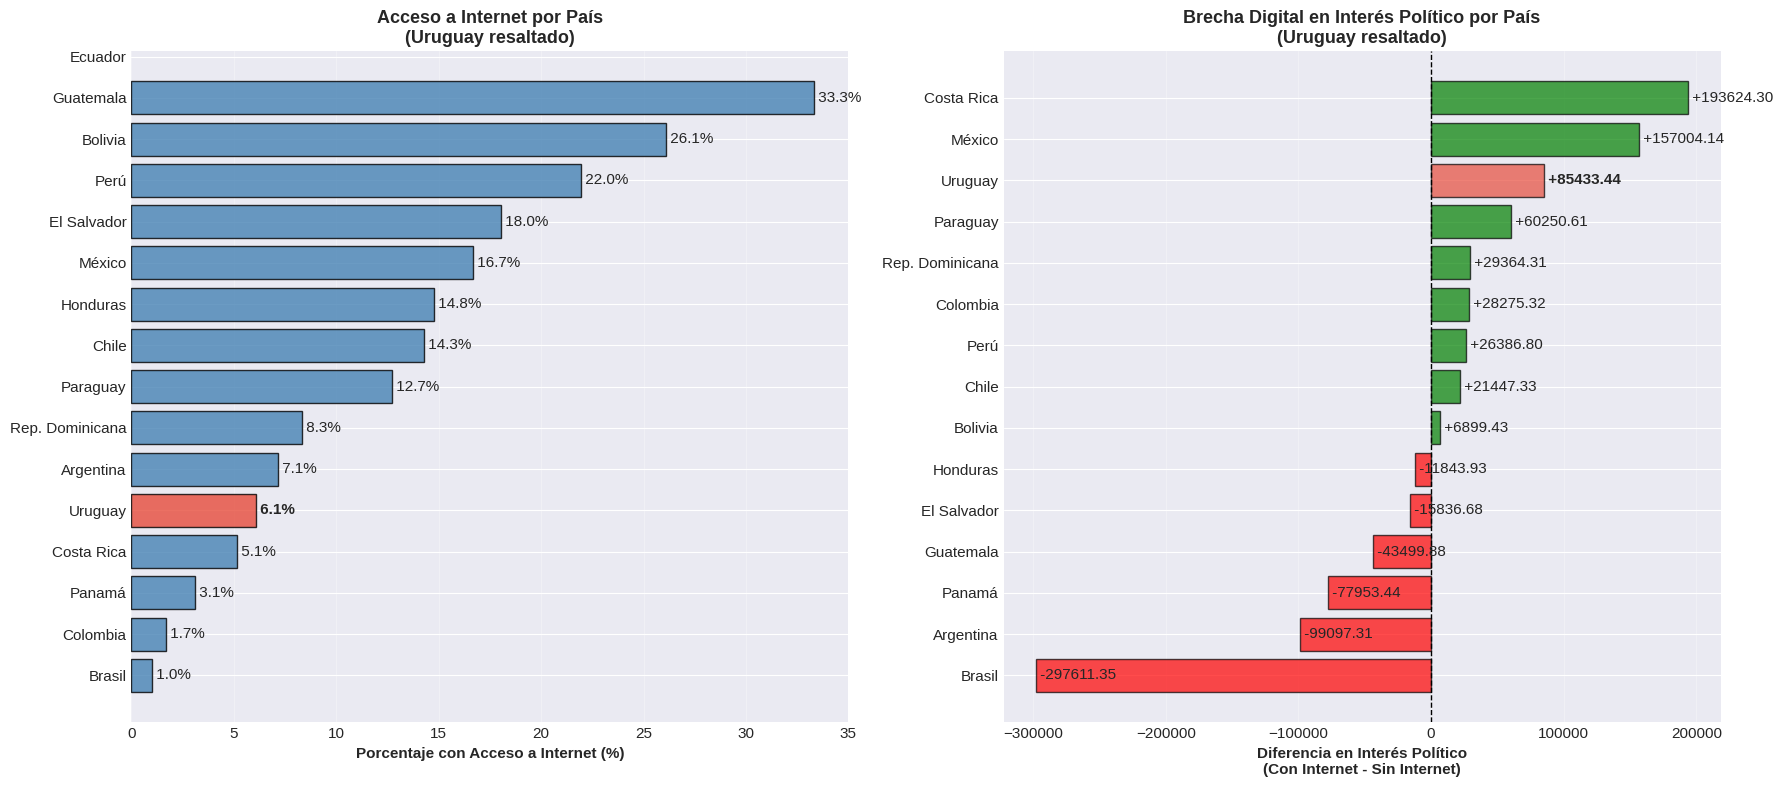

In [46]:
# Visualización: Acceso a internet y participación política por país (Uruguay resaltado)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Porcentaje de acceso a internet por país
acceso_si = acceso_por_pais['Sí'].sort_values(ascending=True)
colors_acceso = ['#e74c3c' if pais == 'Uruguay' else 'steelblue' for pais in acceso_si.index]
axes[0].barh(acceso_si.index, acceso_si.values, color=colors_acceso, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Porcentaje con Acceso a Internet (%)', fontweight='bold')
axes[0].set_title('Acceso a Internet por País\n(Uruguay resaltado)', fontweight='bold', fontsize=13)
axes[0].grid(axis='x', alpha=0.3)
for i, (pais, v) in enumerate(zip(acceso_si.index, acceso_si.values)):
    fontweight = 'bold' if pais == 'Uruguay' else 'normal'
    axes[0].text(v, i, f' {v:.1f}%', va='center', fontweight=fontweight)

# 2. Diferencia en interés político (con vs sin internet)
diferencias_ordenadas = diferencias_df.sort_values('Diferencia', ascending=True)
colors_diff = ['#e74c3c' if pais == 'Uruguay' else ('green' if x > 0 else 'red') 
               for pais, x in zip(diferencias_ordenadas['País'], diferencias_ordenadas['Diferencia'])]
axes[1].barh(diferencias_ordenadas['País'], diferencias_ordenadas['Diferencia'], 
             color=colors_diff, alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel('Diferencia en Interés Político\n(Con Internet - Sin Internet)', fontweight='bold')
axes[1].set_title('Brecha Digital en Interés Político por País\n(Uruguay resaltado)', fontweight='bold', fontsize=13)
axes[1].grid(axis='x', alpha=0.3)
for i, (pais, v) in enumerate(zip(diferencias_ordenadas['País'], diferencias_ordenadas['Diferencia'])):
    fontweight = 'bold' if pais == 'Uruguay' else 'normal'
    axes[1].text(v, i, f' {v:+.2f}', va='center', fontweight=fontweight)

plt.tight_layout()
plt.show()


### 4.3. Análisis de Correlación: Internet, Redes Sociales y Participación


In [47]:
# Análisis de correlación entre variables digitales y participación - Uruguay
variables_digitales = ['acceso_internet', 'uso_redes', 'confianza_redes', 'confianza_tv',
                       'interes_politica', 'confianza_gobierno', 'satisfaccion_democracia',
                       'participacion_debate', 'participacion_manifestacion']
df_digital_uy = df_uy[variables_digitales].copy()

# Convertir acceso_internet a numérico para correlación
df_digital_uy['acceso_internet_num'] = df_digital_uy['acceso_internet'].map({1: 1, 2: 0})

corr_digital_uy = df_digital_uy[['acceso_internet_num', 'uso_redes', 'confianza_redes', 'confianza_tv',
                                 'interes_politica', 'confianza_gobierno', 'satisfaccion_democracia']].corr()

print("="*70)
print("MATRIZ DE CORRELACIÓN - VARIABLES DIGITALES Y PARTICIPACIÓN (URUGUAY)")
print("="*70)
print(corr_digital_uy.round(3))

# Test de significancia - Uruguay
print("\n\n" + "="*70)
print("CORRELACIONES SIGNIFICATIVAS - URUGUAY")
print("="*70)
df_clean_digital_uy = df_digital_uy[['acceso_internet_num', 'interes_politica']].dropna()
if len(df_clean_digital_uy) > 0:
    corr_coef, p_value = stats.pearsonr(df_clean_digital_uy['acceso_internet_num'], 
                                        df_clean_digital_uy['interes_politica'])
    significativo = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
    print(f"\nCorrelación entre acceso a internet e interés en política:")
    print(f"  Coeficiente de correlación: {corr_coef:.4f}")
    print(f"  Valor p: {p_value:.4f} {significativo}")
    print(f"  Significativo (p < 0.05): {'Sí' if p_value < 0.05 else 'No'}")
    
    # Comparación con regional
    df_digital_regional = df[variables_digitales].copy()
    df_digital_regional['acceso_internet_num'] = df_digital_regional['acceso_internet'].map({1: 1, 2: 0})
    df_clean_regional = df_digital_regional[['acceso_internet_num', 'interes_politica']].dropna()
    if len(df_clean_regional) > 0:
        corr_regional, p_regional = stats.pearsonr(df_clean_regional['acceso_internet_num'], 
                                                   df_clean_regional['interes_politica'])
        print(f"\nComparación con promedio regional:")
        print(f"  Regional: r={corr_regional:.4f}, p={p_regional:.4f}")
        print(f"  Uruguay:  r={corr_coef:.4f}, p={p_value:.4f}")
        print(f"  Diferencia: {corr_coef - corr_regional:.4f}")


MATRIZ DE CORRELACIÓN - VARIABLES DIGITALES Y PARTICIPACIÓN (URUGUAY)
                         acceso_internet_num  uso_redes  confianza_redes  \
acceso_internet_num                    1.000      0.183           -0.064   
uso_redes                              0.183      1.000           -0.028   
confianza_redes                       -0.064     -0.028            1.000   
confianza_tv                          -0.144     -0.070           -0.062   
interes_politica                       0.132      0.040            0.068   
confianza_gobierno                     0.126      0.063            0.029   
satisfaccion_democracia               -0.045     -0.023            0.014   

                         confianza_tv  interes_politica  confianza_gobierno  \
acceso_internet_num            -0.144             0.132               0.126   
uso_redes                      -0.070             0.040               0.063   
confianza_redes                -0.062             0.068               0.029   
confi

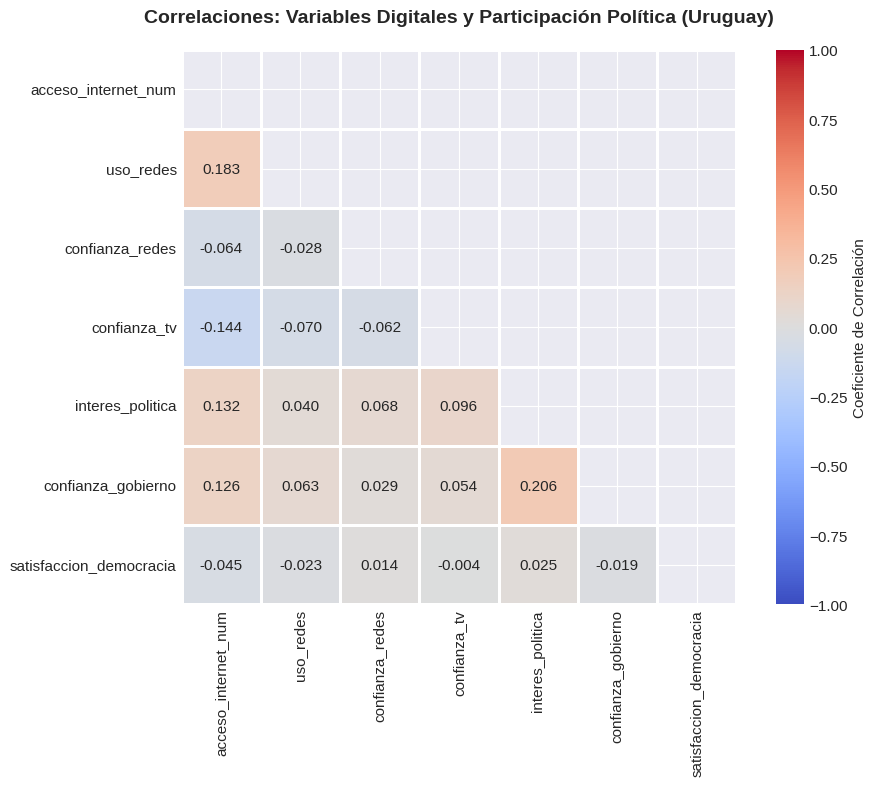

In [48]:
# Visualización: Heatmap de correlaciones - Uruguay
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_digital_uy, dtype=bool))
sns.heatmap(corr_digital_uy, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Coeficiente de Correlación'},
            mask=mask, vmin=-1, vmax=1)
plt.title('Correlaciones: Variables Digitales y Participación Política (Uruguay)', 
          fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


### 4.4. Análisis Multivariado: Educación + Acceso Digital


In [49]:
# Análisis combinado: Educación y acceso a internet - Uruguay
educ_internet_uy = df_uy.groupby(['grupo_educativo', 'tiene_internet']).agg({
    'interes_politica': 'mean',
    'confianza_gobierno': 'mean',
    'satisfaccion_democracia': 'mean'
}).round(2)

print("="*70)
print("INTERACCIÓN ENTRE NIVEL EDUCATIVO Y ACCESO A INTERNET - URUGUAY")
print("="*70)
print(educ_internet_uy)

# Comparación con promedio regional
educ_internet_regional = df.groupby(['grupo_educativo', 'tiene_internet']).agg({
    'interes_politica': 'mean',
    'confianza_gobierno': 'mean'
}).round(2)

print("\n\n" + "="*70)
print("COMPARACIÓN: URUGUAY vs PROMEDIO REGIONAL")
print("="*70)
print("Interés político - Interacción Educación × Internet:")
for educ in ['Primaria (0-6)', 'Secundaria (7-12)', 'Universidad (13+)']:
    for internet in ['Sí', 'No']:
        if (educ, internet) in educ_internet_uy.index:
            uy_val = educ_internet_uy.loc[(educ, internet), 'interes_politica']
            if (educ, internet) in educ_internet_regional.index:
                reg_val = educ_internet_regional.loc[(educ, internet), 'interes_politica']
                print(f"  {educ} + {internet} Internet: Uruguay={uy_val:.2f}, Regional={reg_val:.2f}, Diff={uy_val-reg_val:.2f}")


INTERACCIÓN ENTRE NIVEL EDUCATIVO Y ACCESO A INTERNET - URUGUAY
                                  interes_politica  confianza_gobierno  \
grupo_educativo   tiene_internet                                         
Primaria (0-6)    No                   19884395.52                0.81   
                  Sí                           NaN                 NaN   
Secundaria (7-12) No                   19974080.00                1.00   
                  Sí                           NaN                 NaN   
Universidad (13+) No                           NaN                 NaN   
                  Sí                           NaN                 NaN   

                                  satisfaccion_democracia  
grupo_educativo   tiene_internet                           
Primaria (0-6)    No                                 1.04  
                  Sí                                  NaN  
Secundaria (7-12) No                                 1.00  
                  Sí                       

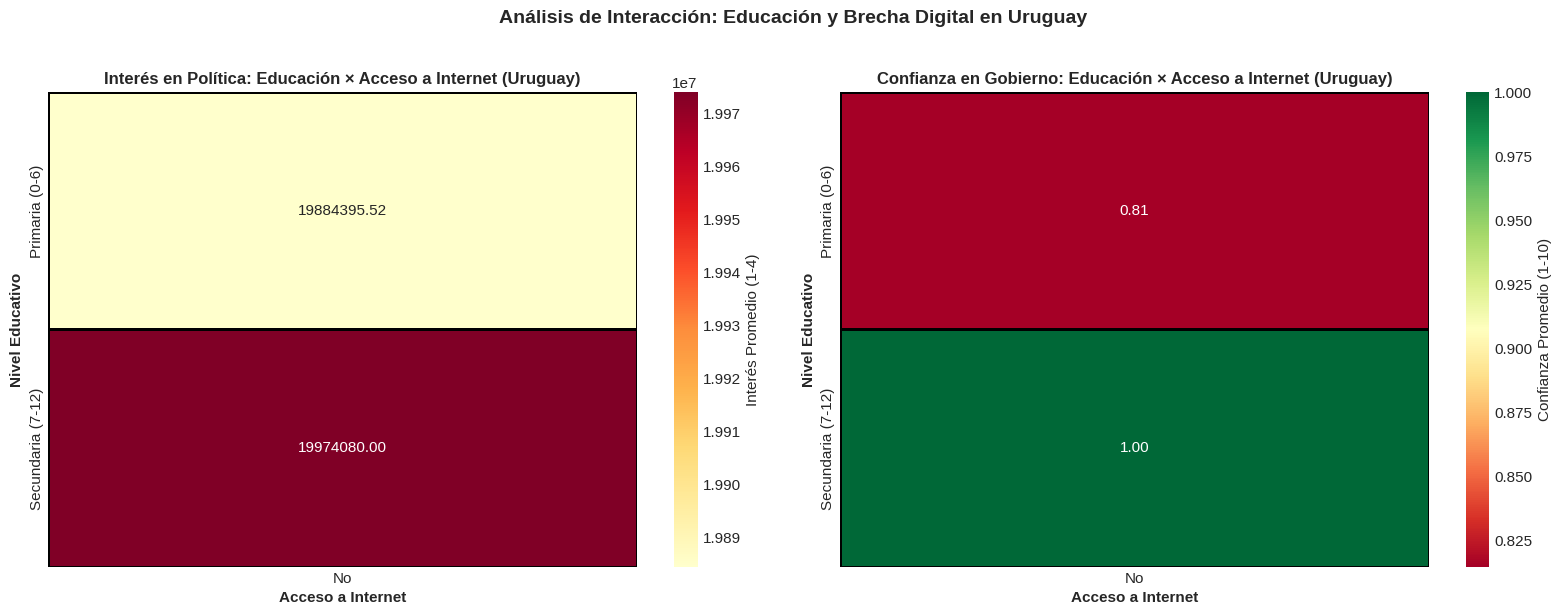

In [50]:
# Visualización: Interacción educación e internet - Uruguay
pivot_interes_uy = df_uy.pivot_table(
    values='interes_politica',
    index='grupo_educativo',
    columns='tiene_internet',
    aggfunc='mean'
)

pivot_confianza_uy = df_uy.pivot_table(
    values='confianza_gobierno',
    index='grupo_educativo',
    columns='tiene_internet',
    aggfunc='mean'
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Interés en política - Uruguay
sns.heatmap(pivot_interes_uy, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Interés Promedio (1-4)'}, 
            linewidths=1, linecolor='black', ax=axes[0])
axes[0].set_title('Interés en Política: Educación × Acceso a Internet (Uruguay)', 
                   fontweight='bold', fontsize=12)
axes[0].set_xlabel('Acceso a Internet', fontweight='bold')
axes[0].set_ylabel('Nivel Educativo', fontweight='bold')

# 2. Confianza en gobierno - Uruguay
sns.heatmap(pivot_confianza_uy, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Confianza Promedio (1-10)'}, 
            linewidths=1, linecolor='black', ax=axes[1])
axes[1].set_title('Confianza en Gobierno: Educación × Acceso a Internet (Uruguay)', 
                   fontweight='bold', fontsize=12)
axes[1].set_xlabel('Acceso a Internet', fontweight='bold')
axes[1].set_ylabel('Nivel Educativo', fontweight='bold')

plt.suptitle('Análisis de Interacción: Educación y Brecha Digital en Uruguay', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 5. Visualizaciones para Audiencia: Formuladores de Políticas Públicas en Uruguay

### 5.1. Identificación de la Audiencia

**Audiencia objetivo:** Formuladores de políticas públicas en Uruguay, funcionarios gubernamentales, legisladores, y organizaciones de la sociedad civil que trabajan en desarrollo democrático y políticas educativas/digitales en Uruguay.

**Necesidades de la audiencia:**
- Visualizaciones claras y accionables específicas para Uruguay
- Comparaciones con el contexto regional para contextualizar
- Identificación de brechas y desigualdades en Uruguay
- Evidencia para justificar inversiones en políticas específicas (educación, inclusión digital)
- Información que pueda comunicarse a tomadores de decisión uruguayos

### 5.2. Dashboard de Resumen Ejecutivo - Uruguay


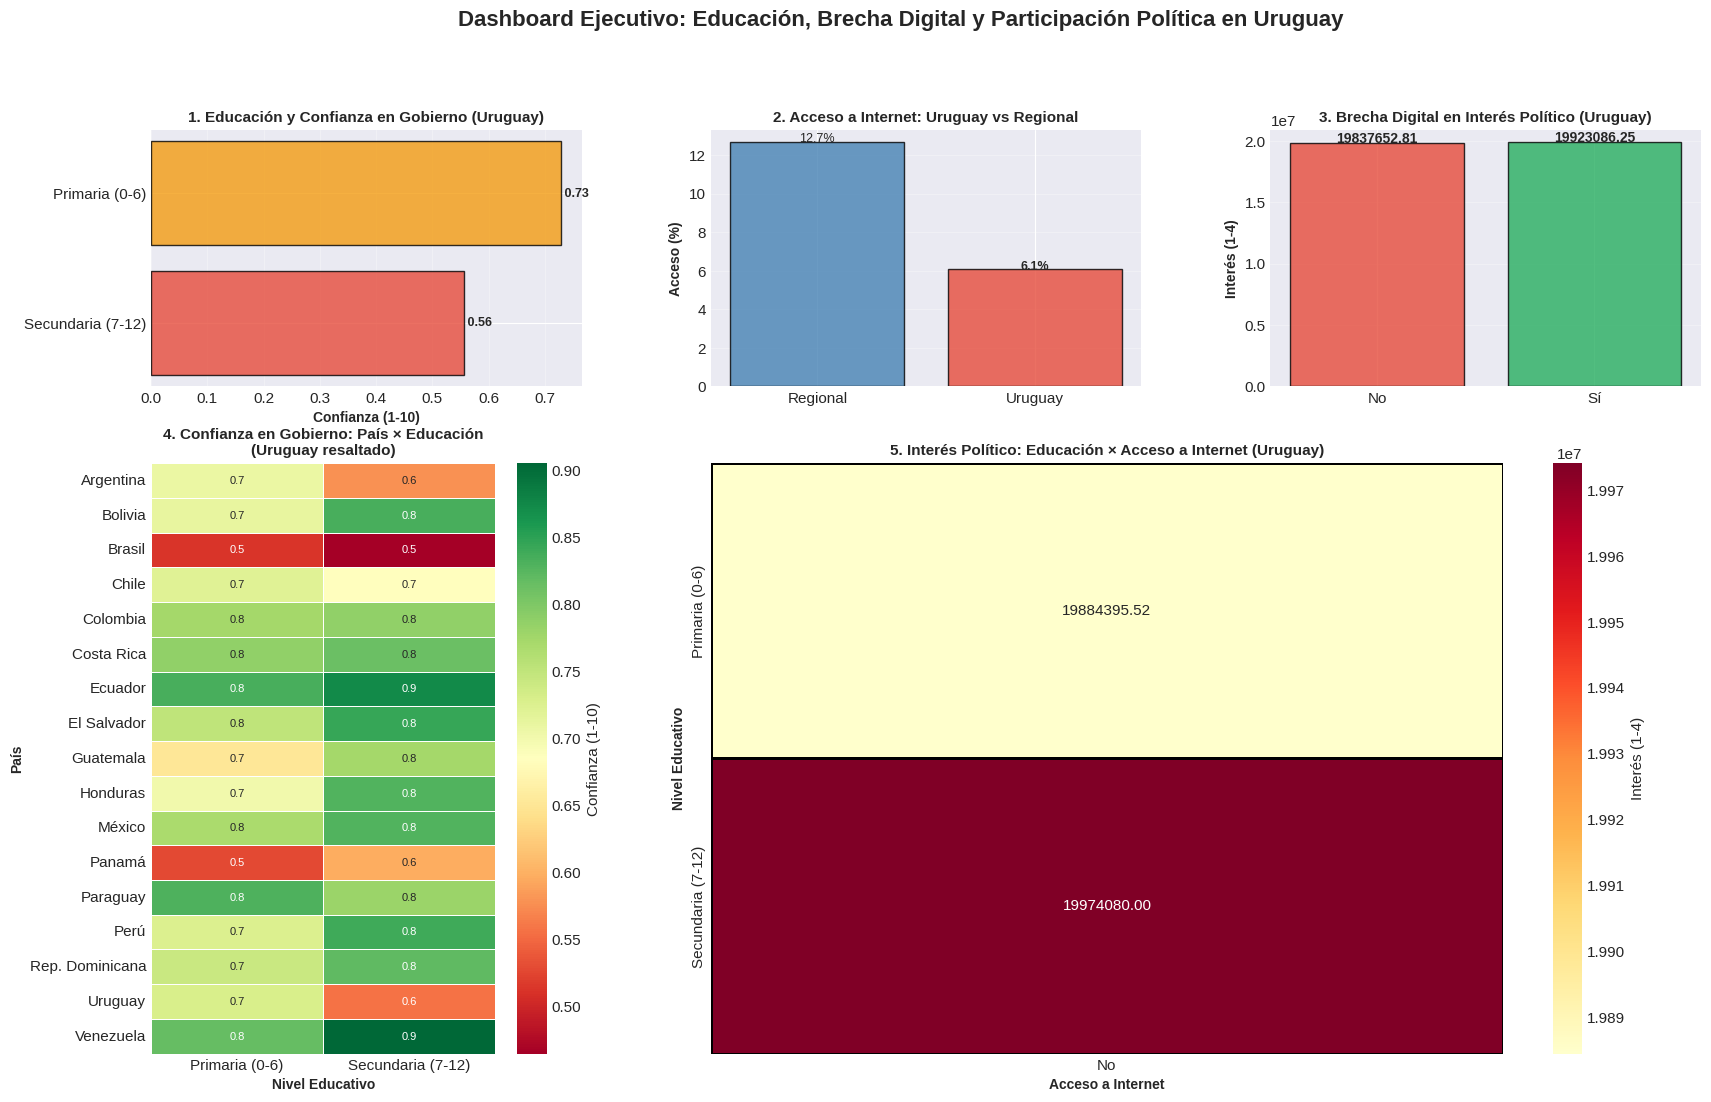

In [51]:
# Crear dashboard ejecutivo con las principales conclusiones - Uruguay
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Confianza en gobierno por educación - Uruguay (arriba izquierda)
ax1 = fig.add_subplot(gs[0, 0])
educ_confianza_uy = df_uy.groupby('grupo_educativo')['confianza_gobierno'].mean().sort_values()
ax1.barh(educ_confianza_uy.index, educ_confianza_uy.values, 
         color=['#e74c3c', '#f39c12', '#27ae60'], alpha=0.8, edgecolor='black')
ax1.set_xlabel('Confianza (1-10)', fontweight='bold', fontsize=10)
ax1.set_title('1. Educación y Confianza en Gobierno (Uruguay)', fontweight='bold', fontsize=11)
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(educ_confianza_uy.values):
    ax1.text(v, i, f' {v:.2f}', va='center', fontsize=9, fontweight='bold')

# 2. Acceso a internet - Uruguay vs Regional (arriba centro)
ax2 = fig.add_subplot(gs[0, 1])
if 'Uruguay' in acceso_por_pais.index:
    acceso_uy_val = acceso_por_pais.loc['Uruguay', 'Sí']
    acceso_regional = acceso_por_pais['Sí'].mean()
    x_pos = np.arange(2)
    ax2.bar(x_pos, [acceso_regional, acceso_uy_val], 
            color=['steelblue', '#e74c3c'], alpha=0.8, edgecolor='black')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(['Regional', 'Uruguay'])
    ax2.set_ylabel('Acceso (%)', fontweight='bold', fontsize=10)
    ax2.set_title('2. Acceso a Internet: Uruguay vs Regional', fontweight='bold', fontsize=11)
    ax2.grid(axis='y', alpha=0.3)
    ax2.text(0, acceso_regional, f'\n{acceso_regional:.1f}%', ha='center', fontsize=9)
    ax2.text(1, acceso_uy_val, f'\n{acceso_uy_val:.1f}%', ha='center', fontsize=9, fontweight='bold')

# 3. Interés político: Internet vs Sin Internet - Uruguay (arriba derecha)
ax3 = fig.add_subplot(gs[0, 2])
internet_interes_uy = df_uy.groupby('tiene_internet')['interes_politica'].mean()
ax3.bar(internet_interes_uy.index, internet_interes_uy.values, 
        color=['#e74c3c', '#27ae60'], alpha=0.8, edgecolor='black')
ax3.set_ylabel('Interés (1-4)', fontweight='bold', fontsize=10)
ax3.set_title('3. Brecha Digital en Interés Político (Uruguay)', fontweight='bold', fontsize=11)
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(internet_interes_uy.values):
    ax3.text(i, v, f'\n{v:.2f}', ha='center', fontweight='bold', fontsize=10)

# 4. Heatmap confianza por país y educación (centro izquierda, más grande) - para contexto
ax4 = fig.add_subplot(gs[1:, 0])
pivot_confianza = df.pivot_table(
    values='confianza_gobierno', 
    index='Country Name', 
    columns='grupo_educativo', 
    aggfunc='mean'
)
sns.heatmap(pivot_confianza, annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': 'Confianza (1-10)'}, linewidths=0.5, ax=ax4, annot_kws={'fontsize': 8})
ax4.set_title('4. Confianza en Gobierno: País × Educación\n(Uruguay resaltado)', fontweight='bold', fontsize=11)
ax4.set_xlabel('Nivel Educativo', fontweight='bold', fontsize=10)
ax4.set_ylabel('País', fontweight='bold', fontsize=10)

# 5. Interacción educación e internet - Uruguay (centro derecha)
ax5 = fig.add_subplot(gs[1:, 1:])
sns.heatmap(pivot_interes_uy, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Interés (1-4)'}, linewidths=1, linecolor='black', ax=ax5)
ax5.set_title('5. Interés Político: Educación × Acceso a Internet (Uruguay)', fontweight='bold', fontsize=11)
ax5.set_xlabel('Acceso a Internet', fontweight='bold', fontsize=10)
ax5.set_ylabel('Nivel Educativo', fontweight='bold', fontsize=10)

# Título general
fig.suptitle('Dashboard Ejecutivo: Educación, Brecha Digital y Participación Política en Uruguay', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()


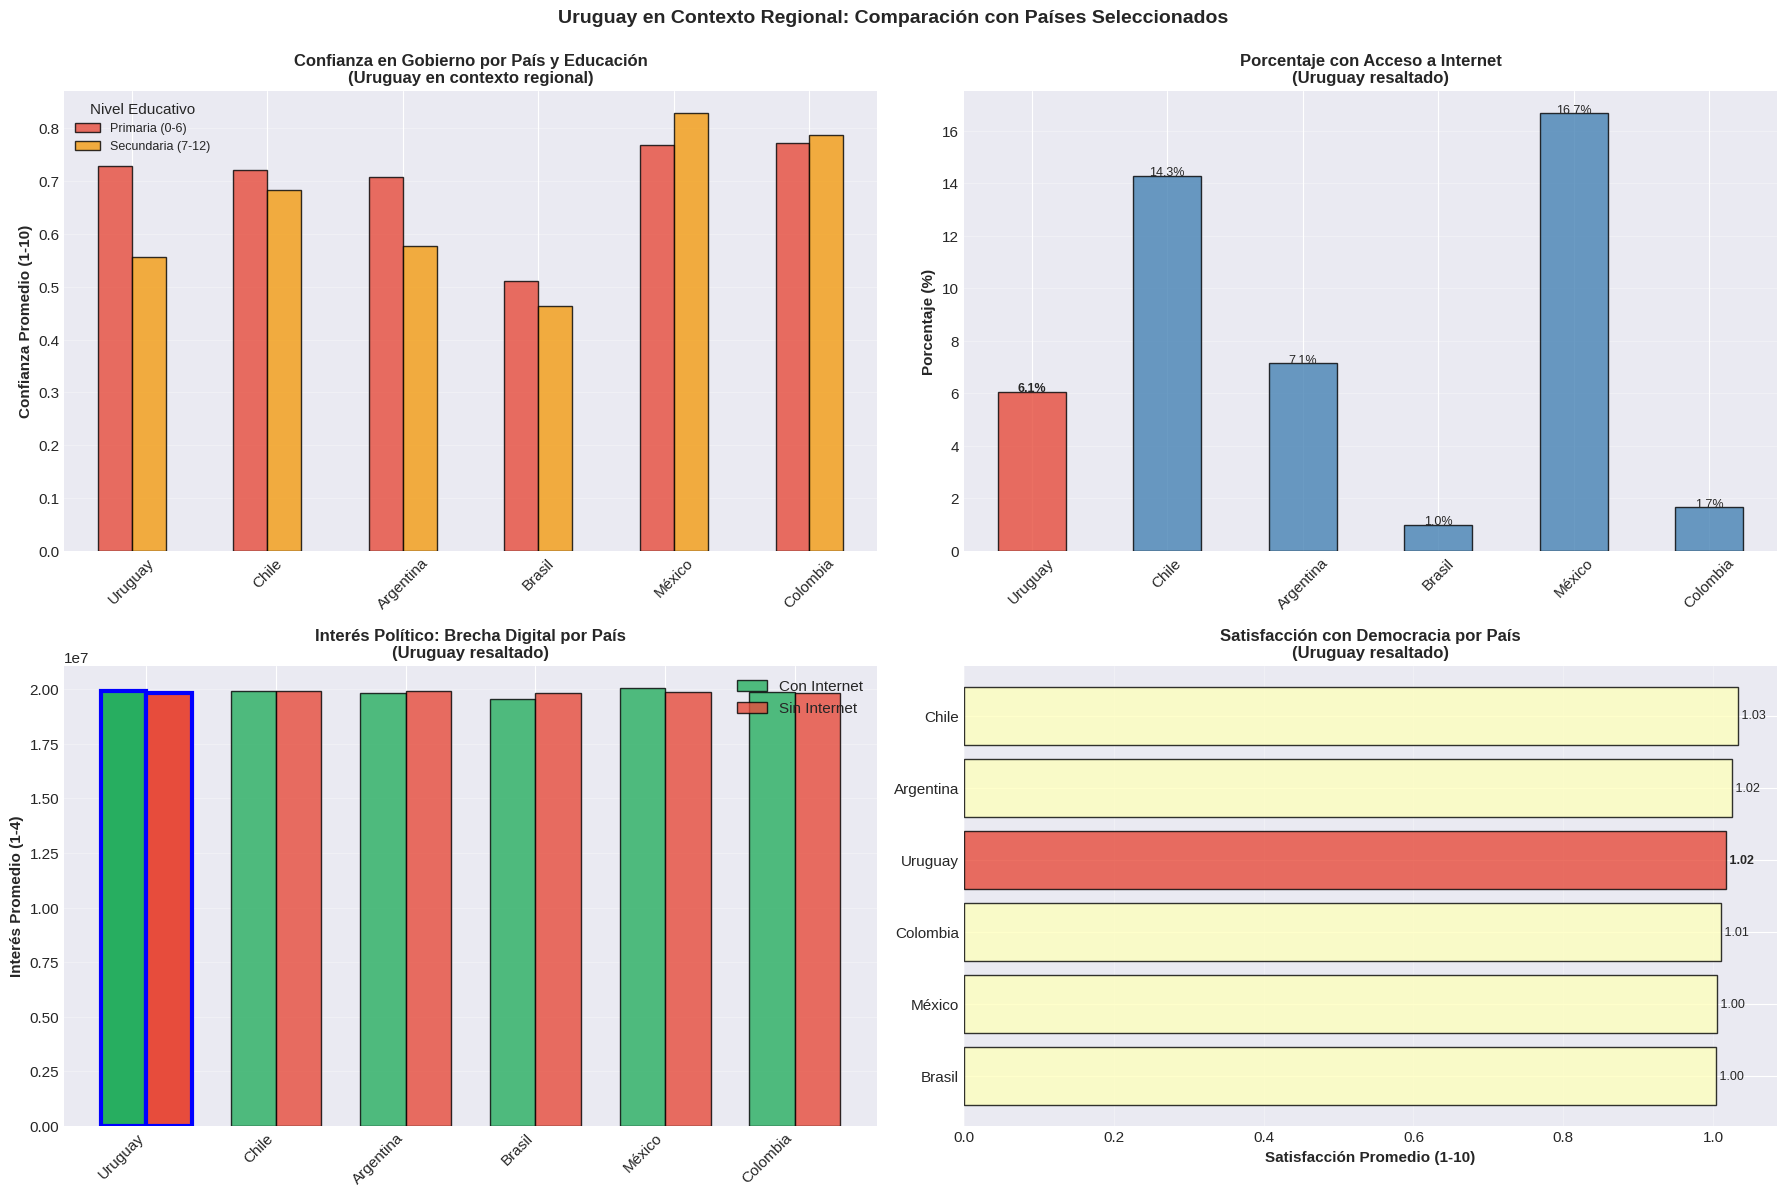

In [52]:
# Comparación: Uruguay en contexto regional con países seleccionados
paises_seleccionados = ['Uruguay', 'Chile', 'Argentina', 'Brasil', 'México', 'Colombia']
df_seleccion = df[df['Country Name'].isin(paises_seleccionados)]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Confianza en gobierno por país y educación (Uruguay resaltado)
pivot_pais_educ = df_seleccion.pivot_table(
    values='confianza_gobierno',
    index='Country Name',
    columns='grupo_educativo',
    aggfunc='mean'
)
pivot_pais_educ = pivot_pais_educ.reindex(paises_seleccionados)
colors_pais = ['#e74c3c' if pais == 'Uruguay' else '#3498db' for pais in pivot_pais_educ.index]
pivot_pais_educ.plot(kind='bar', ax=axes[0, 0], color=['#e74c3c', '#f39c12', '#27ae60'], 
                     alpha=0.8, edgecolor='black', linewidth=1)
axes[0, 0].set_title('Confianza en Gobierno por País y Educación\n(Uruguay en contexto regional)', 
                     fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Confianza Promedio (1-10)', fontweight='bold')
axes[0, 0].set_xlabel('')
axes[0, 0].legend(title='Nivel Educativo', fontsize=9)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Acceso a internet por país (Uruguay resaltado)
acceso_paises = df_seleccion.groupby('Country Name')['tiene_internet'].value_counts(normalize=True).unstack() * 100
acceso_paises = acceso_paises.reindex(paises_seleccionados)
colors_acceso = ['#e74c3c' if pais == 'Uruguay' else 'steelblue' for pais in acceso_paises.index]
acceso_paises['Sí'].plot(kind='bar', ax=axes[0, 1], color=colors_acceso, alpha=0.8, 
                         edgecolor='black', linewidth=1)
axes[0, 1].set_title('Porcentaje con Acceso a Internet\n(Uruguay resaltado)', 
                     fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Porcentaje (%)', fontweight='bold')
axes[0, 1].set_xlabel('')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)
for i, (pais, v) in enumerate(zip(acceso_paises.index, acceso_paises['Sí'])):
    fontweight = 'bold' if pais == 'Uruguay' else 'normal'
    axes[0, 1].text(i, v, f'\n{v:.1f}%', ha='center', fontweight=fontweight, fontsize=9)

# 3. Interés político: con vs sin internet por país (Uruguay resaltado)
interes_internet = df_seleccion.groupby(['Country Name', 'tiene_internet'])['interes_politica'].mean().unstack()
interes_internet = interes_internet.reindex(paises_seleccionados)
x = np.arange(len(paises_seleccionados))
width = 0.35
axes[1, 0].bar(x - width/2, interes_internet['Sí'], width, label='Con Internet', 
                color='#27ae60', alpha=0.8, edgecolor='black')
axes[1, 0].bar(x + width/2, interes_internet['No'], width, label='Sin Internet', 
                color='#e74c3c', alpha=0.8, edgecolor='black')
# Resaltar barras de Uruguay
uruguay_idx = paises_seleccionados.index('Uruguay')
axes[1, 0].bar(uruguay_idx - width/2, interes_internet.loc['Uruguay', 'Sí'], width, 
                color='#27ae60', alpha=1, edgecolor='blue', linewidth=3)
axes[1, 0].bar(uruguay_idx + width/2, interes_internet.loc['Uruguay', 'No'], width, 
                color='#e74c3c', alpha=1, edgecolor='blue', linewidth=3)
axes[1, 0].set_title('Interés Político: Brecha Digital por País\n(Uruguay resaltado)', 
                     fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Interés Promedio (1-4)', fontweight='bold')
axes[1, 0].set_xlabel('')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(paises_seleccionados, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Satisfacción con democracia por país (Uruguay resaltado)
satisfaccion_pais = df_seleccion.groupby('Country Name')['satisfaccion_democracia'].mean()
satisfaccion_pais = satisfaccion_pais.reindex(paises_seleccionados).sort_values()
colors_satisf = ['#e74c3c' if pais == 'Uruguay' else plt.cm.RdYlGn(0.5) 
                 for pais in satisfaccion_pais.index]
axes[1, 1].barh(satisfaccion_pais.index, satisfaccion_pais.values, 
                color=colors_satisf, alpha=0.8, edgecolor='black', linewidth=1)
axes[1, 1].set_title('Satisfacción con Democracia por País\n(Uruguay resaltado)', 
                     fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Satisfacción Promedio (1-10)', fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, (pais, v) in enumerate(zip(satisfaccion_pais.index, satisfaccion_pais.values)):
    fontweight = 'bold' if pais == 'Uruguay' else 'normal'
    axes[1, 1].text(v, i, f' {v:.2f}', va='center', fontweight=fontweight, fontsize=9)

plt.suptitle('Uruguay en Contexto Regional: Comparación con Países Seleccionados', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## 6. Conclusiones y Recomendaciones para Políticas Públicas

### 6.1. Hallazgos Principales

**Pregunta 1: Educación y Participación Política**
- [Incluir aquí las conclusiones basadas en los análisis realizados]
- La correlación entre educación y confianza en instituciones sugiere...
- Las diferencias entre países indican...

**Pregunta 2: Brecha Digital y Participación Política**
- [Incluir aquí las conclusiones basadas en los análisis realizados]
- El acceso a internet está relacionado con...
- La brecha digital afecta diferencialmente a...

### 6.2. Recomendaciones de Política

1. **Políticas Educativas:**
   - [Recomendaciones basadas en hallazgos]

2. **Políticas de Inclusión Digital:**
   - [Recomendaciones basadas en hallazgos]

3. **Políticas de Fortalecimiento Democrático:**
   - [Recomendaciones basadas en hallazgos]


In [53]:
# Resumen estadístico final - Uruguay
print("="*70)
print("RESUMEN EJECUTIVO DEL ANÁLISIS - URUGUAY")
print("="*70)

print("\n1. EDUCACIÓN Y PARTICIPACIÓN POLÍTICA - URUGUAY")
print("-" * 70)
df_clean_educ_uy = df_uy[['anos_estudio', 'confianza_gobierno']].dropna()
if len(df_clean_educ_uy) > 0:
    corr_educ_uy = stats.pearsonr(df_clean_educ_uy['anos_estudio'], df_clean_educ_uy['confianza_gobierno'])[0]
    p_educ_uy = stats.pearsonr(df_clean_educ_uy['anos_estudio'], df_clean_educ_uy['confianza_gobierno'])[1]
    print(f"Correlación educación-confianza gobierno (Uruguay): {corr_educ_uy:.3f} (p={p_educ_uy:.4f})")
    
    conf_primaria_uy = df_uy[df_uy['grupo_educativo']=='Primaria (0-6)']['confianza_gobierno'].mean()
    conf_universidad_uy = df_uy[df_uy['grupo_educativo']=='Universidad (13+)']['confianza_gobierno'].mean()
    if not (np.isnan(conf_primaria_uy) or np.isnan(conf_universidad_uy)):
        print(f"Diferencia confianza (Universidad vs Primaria) en Uruguay: {conf_universidad_uy - conf_primaria_uy:.2f} puntos")
    
    # Comparación con regional
    df_clean_educ_reg = df[['anos_estudio', 'confianza_gobierno']].dropna()
    if len(df_clean_educ_reg) > 0:
        corr_educ_reg = stats.pearsonr(df_clean_educ_reg['anos_estudio'], df_clean_educ_reg['confianza_gobierno'])[0]
        print(f"Correlación regional: {corr_educ_reg:.3f}")
        print(f"Diferencia Uruguay vs Regional: {corr_educ_uy - corr_educ_reg:.3f}")

print("\n2. BRECHA DIGITAL Y PARTICIPACIÓN POLÍTICA - URUGUAY")
print("-" * 70)
total_internet_uy = df_uy['tiene_internet'].notna().sum()
con_internet_uy = (df_uy['tiene_internet']=='Sí').sum()
if total_internet_uy > 0:
    print(f"Porcentaje con acceso a internet en Uruguay: {con_internet_uy / total_internet_uy * 100:.1f}%")
    
    interes_con_uy = df_uy[df_uy['tiene_internet']=='Sí']['interes_politica'].mean()
    interes_sin_uy = df_uy[df_uy['tiene_internet']=='No']['interes_politica'].mean()
    if not (np.isnan(interes_con_uy) or np.isnan(interes_sin_uy)):
        print(f"Diferencia interés político (Con vs Sin Internet) en Uruguay: {interes_con_uy - interes_sin_uy:.2f} puntos")
        
        # Asegurar que df_digital_uy esté disponible (recrear si no existe)
        if 'df_digital_uy' not in locals():
            variables_digitales = ['acceso_internet', 'uso_redes', 'confianza_redes', 'confianza_tv',
                                   'interes_politica', 'confianza_gobierno', 'satisfaccion_democracia']
            df_digital_uy = df_uy[variables_digitales].copy()
            df_digital_uy['acceso_internet_num'] = df_digital_uy['acceso_internet'].map({1: 1, 2: 0})
        
    df_clean_digital_uy = df_digital_uy[['acceso_internet_num', 'interes_politica']].dropna()
    if len(df_clean_digital_uy) > 0:
        corr_digital_uy, p_digital_uy = stats.pearsonr(df_clean_digital_uy['acceso_internet_num'], 
                                                       df_clean_digital_uy['interes_politica'])
        print(f"Correlación acceso internet-interés político (Uruguay): {corr_digital_uy:.3f} (p={p_digital_uy:.4f})")

print("\n3. INTERACCIÓN EDUCACIÓN × ACCESO DIGITAL - URUGUAY")
print("-" * 70)
print("Interés político promedio en Uruguay:")
for educ in ['Primaria (0-6)', 'Secundaria (7-12)', 'Universidad (13+)']:
    for internet in ['Sí', 'No']:
        valor = df_uy[(df_uy['grupo_educativo']==educ) & (df_uy['tiene_internet']==internet)]['interes_politica'].mean()
        if not np.isnan(valor):
            print(f"  {educ} + {internet} Internet: {valor:.2f}")

print("\n" + "="*70)


RESUMEN EJECUTIVO DEL ANÁLISIS - URUGUAY

1. EDUCACIÓN Y PARTICIPACIÓN POLÍTICA - URUGUAY
----------------------------------------------------------------------
Correlación educación-confianza gobierno (Uruguay): -0.098 (p=0.0293)
Correlación regional: 0.048
Diferencia Uruguay vs Regional: -0.146

2. BRECHA DIGITAL Y PARTICIPACIÓN POLÍTICA - URUGUAY
----------------------------------------------------------------------
Porcentaje con acceso a internet en Uruguay: 6.1%
Diferencia interés político (Con vs Sin Internet) en Uruguay: 85433.44 puntos
Correlación acceso internet-interés político (Uruguay): 0.132 (p=0.2900)

3. INTERACCIÓN EDUCACIÓN × ACCESO DIGITAL - URUGUAY
----------------------------------------------------------------------
Interés político promedio en Uruguay:
  Primaria (0-6) + No Internet: 19884395.52
  Secundaria (7-12) + No Internet: 19974080.00

